# Imports & globals

In [2]:
import sys
CODE_DIR = "/home/cbarkhof/fall-2021" # <-- change the path to your code directory
sys.path.append("bda_models")
sys.path.append(CODE_DIR)
sys.path.append(f"{CODE_DIR}/analysis")

In [3]:
import os
import torch
import pickle
import pandas as pd
import numpy as np
from tabulate import tabulate

%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns; sns.set()
import torch.distributions as td

# c_cycler, cmap
from plot_utils import *

from analysis.bda_models.bda_dp_mixture_surprisal_vals import *

In [10]:
SAVE_DIR = "data_space/output_files"

# PTB - Topics
TOPIC_MODEL_SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/topic_model_surprisal_values.pt" # <-- output of Notebook fall-2021/analysis/data_space/surprisal_DPs.ipynb
TOPIC_MODEL_SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/topic_model_surprisal_dp_mixtures.pt" # <-- output of ,,

# PTB - Sequence length
SEQUENCE_LEN_SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/sequence_len_surprisal_values.pt" # <-- output of ,,
SEQUENCE_LEN_SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/sequence_length_surprisal_dp_mixtures.pt" # <-- output of ,,

# MNIST
MNIST_SAVE_BDA_SURPRISAL_VALS_FILE = f"{SAVE_DIR}/MNIST_surprisal_values.pt" # <-- output of ,,
MNIST_SAVE_SURPRISAL_DP_FILE = f"{SAVE_DIR}/MNIST_surprisal_dp_mixtures.pt" # <-- output of ,,

# KL of BDA analysis of latent space
KL_LATENT_BDA_IMAGE = "latent_space/image_latent_kl.pt"  # <-- output of Notebook fall-2021/analysis/latent_space/latent_space_analysis.ipynb
KL_LATENT_BDA_LANGUAGE = "latent_space/language_latent_kl.pt" # <-- output of ,,

# Fetch the experiments we want to analyse

In [5]:
overview_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/final_selection_runs.csv", index_col=0)

global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[(global_stats_df.index.isin(overview_df.index)) \
                                  & (global_stats_df.phase == "valid")]

N_exp_ptb = len(overview_df[overview_df.image_or_language == "language"])
N_exp_mnist = len(overview_df[overview_df.image_or_language == "image"])
print("Number of language models:", N_exp_ptb)
print("Number of image models:", N_exp_mnist)
      
overview_df.head()

Number of language models: 23
Number of image models: 64


,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,1,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++,INFO-VAE,0.1,bmnist,image,0.0,0,0,1,cond_pixel_cnn_pp,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,10,basic_deconv_decoder,"(20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++,INFO-VAE,0.1,bmnist,image,0.0,0,0,10,cond_pixel_cnn_pp,"(20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd..."
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,100,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."


# Load the fitted DPs

In [11]:
all_dps = dict(
    ptb_sequence_len=pickle.load(open(SEQUENCE_LEN_SAVE_SURPRISAL_DP_FILE, "rb")),
    ptb_topics=pickle.load(open(TOPIC_MODEL_SAVE_SURPRISAL_DP_FILE, "rb")),
    mnist=pickle.load(open(MNIST_SAVE_SURPRISAL_DP_FILE, "rb"))
)

In [12]:
for bda_task, dp_dict in all_dps.items():
    N_exp = N_exp_ptb if "ptb"in bda_task else N_exp_mnist
    for stat_name, dp in dp_dict.items():
        print("-"*50)
        print(bda_task, stat_name)
        print(f"num_comp={dp.T}", f"num_groups={len(dp.group_names)}", f"num_samples={dp.num_samples} "
              f"corresponds with overview_df={len(dp.group_names) == N_exp+1}")

--------------------------------------------------
ptb_sequence_len unconditional_unconditional
num_comp=5 num_groups=24 num_samples=1200 corresponds with overview_df=True
--------------------------------------------------
ptb_sequence_len unconditional_conditional
num_comp=5 num_groups=24 num_samples=1200 corresponds with overview_df=True
--------------------------------------------------
ptb_sequence_len conditional_conditional
num_comp=5 num_groups=24 num_samples=1200 corresponds with overview_df=True
--------------------------------------------------
ptb_topics unconditional_unconditional
num_comp=5 num_groups=24 num_samples=1200 corresponds with overview_df=True
--------------------------------------------------
ptb_topics unconditional_conditional
num_comp=5 num_groups=24 num_samples=1200 corresponds with overview_df=True
--------------------------------------------------
ptb_topics conditional_conditional
num_comp=5 num_groups=24 num_samples=1200 corresponds with overview_df=Tru

# Compute KL between group component assignments under DPs

In [13]:
all_kls = dict()

# --------------------------------------------------------------------------
# DATA SPACE
for bda_task, dp_dict in all_dps.items():
    print(bda_task)
    all_kls[bda_task] = dict()
    for stat_name, dp in dp_dict.items():
        kl_avg, kl_dists = kl_component_dist_and_data_group_distance(dp)
        
        all_kls[bda_task][stat_name] = dict(
            kl_avg=pd.DataFrame(pd.Series(kl_avg, name="Avg. KL comp")),
            kl_dists=kl_dists
        )

# --------------------------------------------------------------------------
# LATENT SPACE
kl_image_latents = torch.load(KL_LATENT_BDA_IMAGE)
kl_image_latents["kl_avg"] = pd.DataFrame(pd.Series(kl_image_latents["kl_avg"], name="Avg. KL comp"))

kl_language_latents = torch.load(KL_LATENT_BDA_LANGUAGE)
kl_language_latents["kl_avg"] = pd.DataFrame(pd.Series(kl_language_latents["kl_avg"], name="Avg. KL comp"))

ptb_sequence_len
ptb_topics
mnist


# Plot the KL against intrinsic evaluation metrics

In [14]:
def KL_plot(global_stats_df, image_or_language, kl_data, c_dict_plot, title, upper_x_lim_LL_bar = 150, max_groups=100):
    #--------------------------------------------------------------------------------
    # Organise intrinsic evaluation metrics we are plotting alongside the KLs (LL, R, D)
    global_stats_df = global_stats_df.sort_values("IW LL")
    group_names = global_stats_df[global_stats_df.image_or_language == image_or_language].index.values[::-1]
    group_names = [g for g in group_names if g in kl_data["unconditional_unconditional"]["kl_avg"].index.values]

    max_nll = - global_stats_df[global_stats_df.image_or_language == image_or_language]["IW LL"].min()
    min_nll = - global_stats_df[global_stats_df.image_or_language == image_or_language]["IW LL"].max()

    # Columns left to right: 
    #    1: (LL, r, D), 
    #    2: unconditional_unconditional KL
    #    3: unconditional_conditional KL
    #    4: conditional_conditional KL
    #    5: latent KL
    ncols = 5
    nrows = len(group_names)
    
    #--------------------------------------------------------------------------------
    # Set-up plot
    row_h = 0.5
    col_w = 4
    
    # Height ratios KL plots
    height_ratios = []
    for _ in range(nrows):
        # KL distribution axis with respect to average KL bar axis (2:1)
        # applies to columns 1-5
        height_ratios.extend([2, 1]) 
    
    # Gridspec & suplots set-up
    fig = plt.figure(figsize=(col_w*ncols, row_h*nrows)) #constrained_layout=True, 
    gs = GridSpec(ncols=ncols, 
                  nrows=nrows*2, 
                  figure=fig, 
                  height_ratios=height_ratios,
                  wspace=0.0, 
                  hspace=0.0) #
    
    #--------------------------------------------------------------------------------
    # Plot the intrinsic evaluation statistics (horizontal grouped bar, first column)
    
    group_n = 0
    for group_name in group_names:
        if group_name == "data_group": continue
            
        # 1 row in this column corresponds to two rows in the other columns
        row = group_n * 2
        ax = fig.add_subplot(gs[row:row+2, 0])
        
        # Set x_lim
        if upper_x_lim_LL_bar is None:
            ax.set_xlim([0, max_nll*1.1])
        else:
            ax.set_xlim([0, upper_x_lim_LL_bar])
        
        # Set a legend at the first row only
        if row == 0:
            legend_elements = [matplotlib.patches.Patch(facecolor=c_dict_plot["rate"], edgecolor='w', label='Rate'),
                               matplotlib.patches.Patch(facecolor=c_dict_plot["distortion"], edgecolor='w', label='Distortion'),
                               matplotlib.patches.Patch(facecolor=c_dict_plot["nll"], edgecolor='w', label='- IW LL')]
            ax.legend(handles=legend_elements, loc=(0.0, 1.25))
        
        # Set the group name left of this column
        ax.set_ylabel(group_name, rotation="horizontal", ha='right', size=10, y=0.1)

        # Get R, D, LL values for group
        select = global_stats_df[global_stats_df.index == group_name]
        nll, r, d = - select["IW LL"].values[0], select["kl_prior_post"].values[0], select["distortion"].values[0]

        # Grouped bar
        widths = [r, d, nll]
        ax.barh(["Rate", "Distortion", "NLL"], width=widths, color=[c_dict_plot["rate"], c_dict_plot["distortion"], c_dict_plot["nll"]])
        
        # No y ticks
        ax.set_yticks([])
        ax.set_yticklabels([])
        
        group_n += 1
        
        # No x ticks, unless bottom row
        if group_n != len(group_names):
            ax.set_xticklabels([])
        else:
            # Prune the upper label not to overlap with the first label of the next column
            ax.xaxis.set_major_locator(MaxNLocator(prune='upper'))
        
        # Do not plot all groups (for testing purposes)
        if group_n == max_groups: break

    #--------------------------------------------------------------------------------
    # Plot KL distributions and average KLs (all other columns)
    
    for stat_i, (stat_name, kls) in enumerate(test_kl.items()):
        # Start at column 1
        col = stat_i + 1
        
        # Get average KL and 'distribution' of KL values for all groups
        kl_avg = kls["kl_avg"]
        kl_dists = kls["kl_dists"]

        max_avg_kl = kl_avg.max()["Avg. KL comp"]
        
        group_n = 0
        for group_name in group_names:
            # Every group takes up two rows (histogram and bar)
            row = group_n * 2
            
            # Get average KL and 'distribution' of KL values for one specific group
            dist = kl_dists[group_name]
            avg = kl_avg.iloc[kl_avg.index == group_name]["Avg. KL comp"].values[0]
            
            # Make axes to plot on
            dist_ax = fig.add_subplot(gs[row, col])
            avg_ax = fig.add_subplot(gs[row+1, col])
            
            # Set column title (row = 0)
            # if row == 0:
            #      dist_ax.set_title(stat_name)
                
            if row == 0:
                legend_elements = [matplotlib.patches.Patch(facecolor=c_dict_plot[stat_name], edgecolor='w', label=stat_name)]
                dist_ax.legend(handles=legend_elements, loc=(0.0, 1.25))

            dist_ax.hist(dist, bins=40, density=True, color=c_dict_plot[stat_name], alpha=0.4, lw=0)
            avg_ax.barh([group_name], [avg], color=c_dict_plot[stat_name], lw=0)

            dist_ax.set_xlim([0, max_avg_kl*1.1])
            avg_ax.set_xlim([0, max_avg_kl*1.1])

            dist_ax.set_yticks([])
            avg_ax.set_yticks([])

            dist_ax.set_yticklabels([])
            avg_ax.set_yticklabels([])

            group_n += 1

            dist_ax.set_xticklabels([])
            if group_n != len(group_names):
                avg_ax.set_xticklabels([])
            
            # Do not plot all groups (for testing purposes)
            if group_n == max_groups: break
    
    plt.suptitle(title, size=16) #, y=1.03
    plt.show()
    

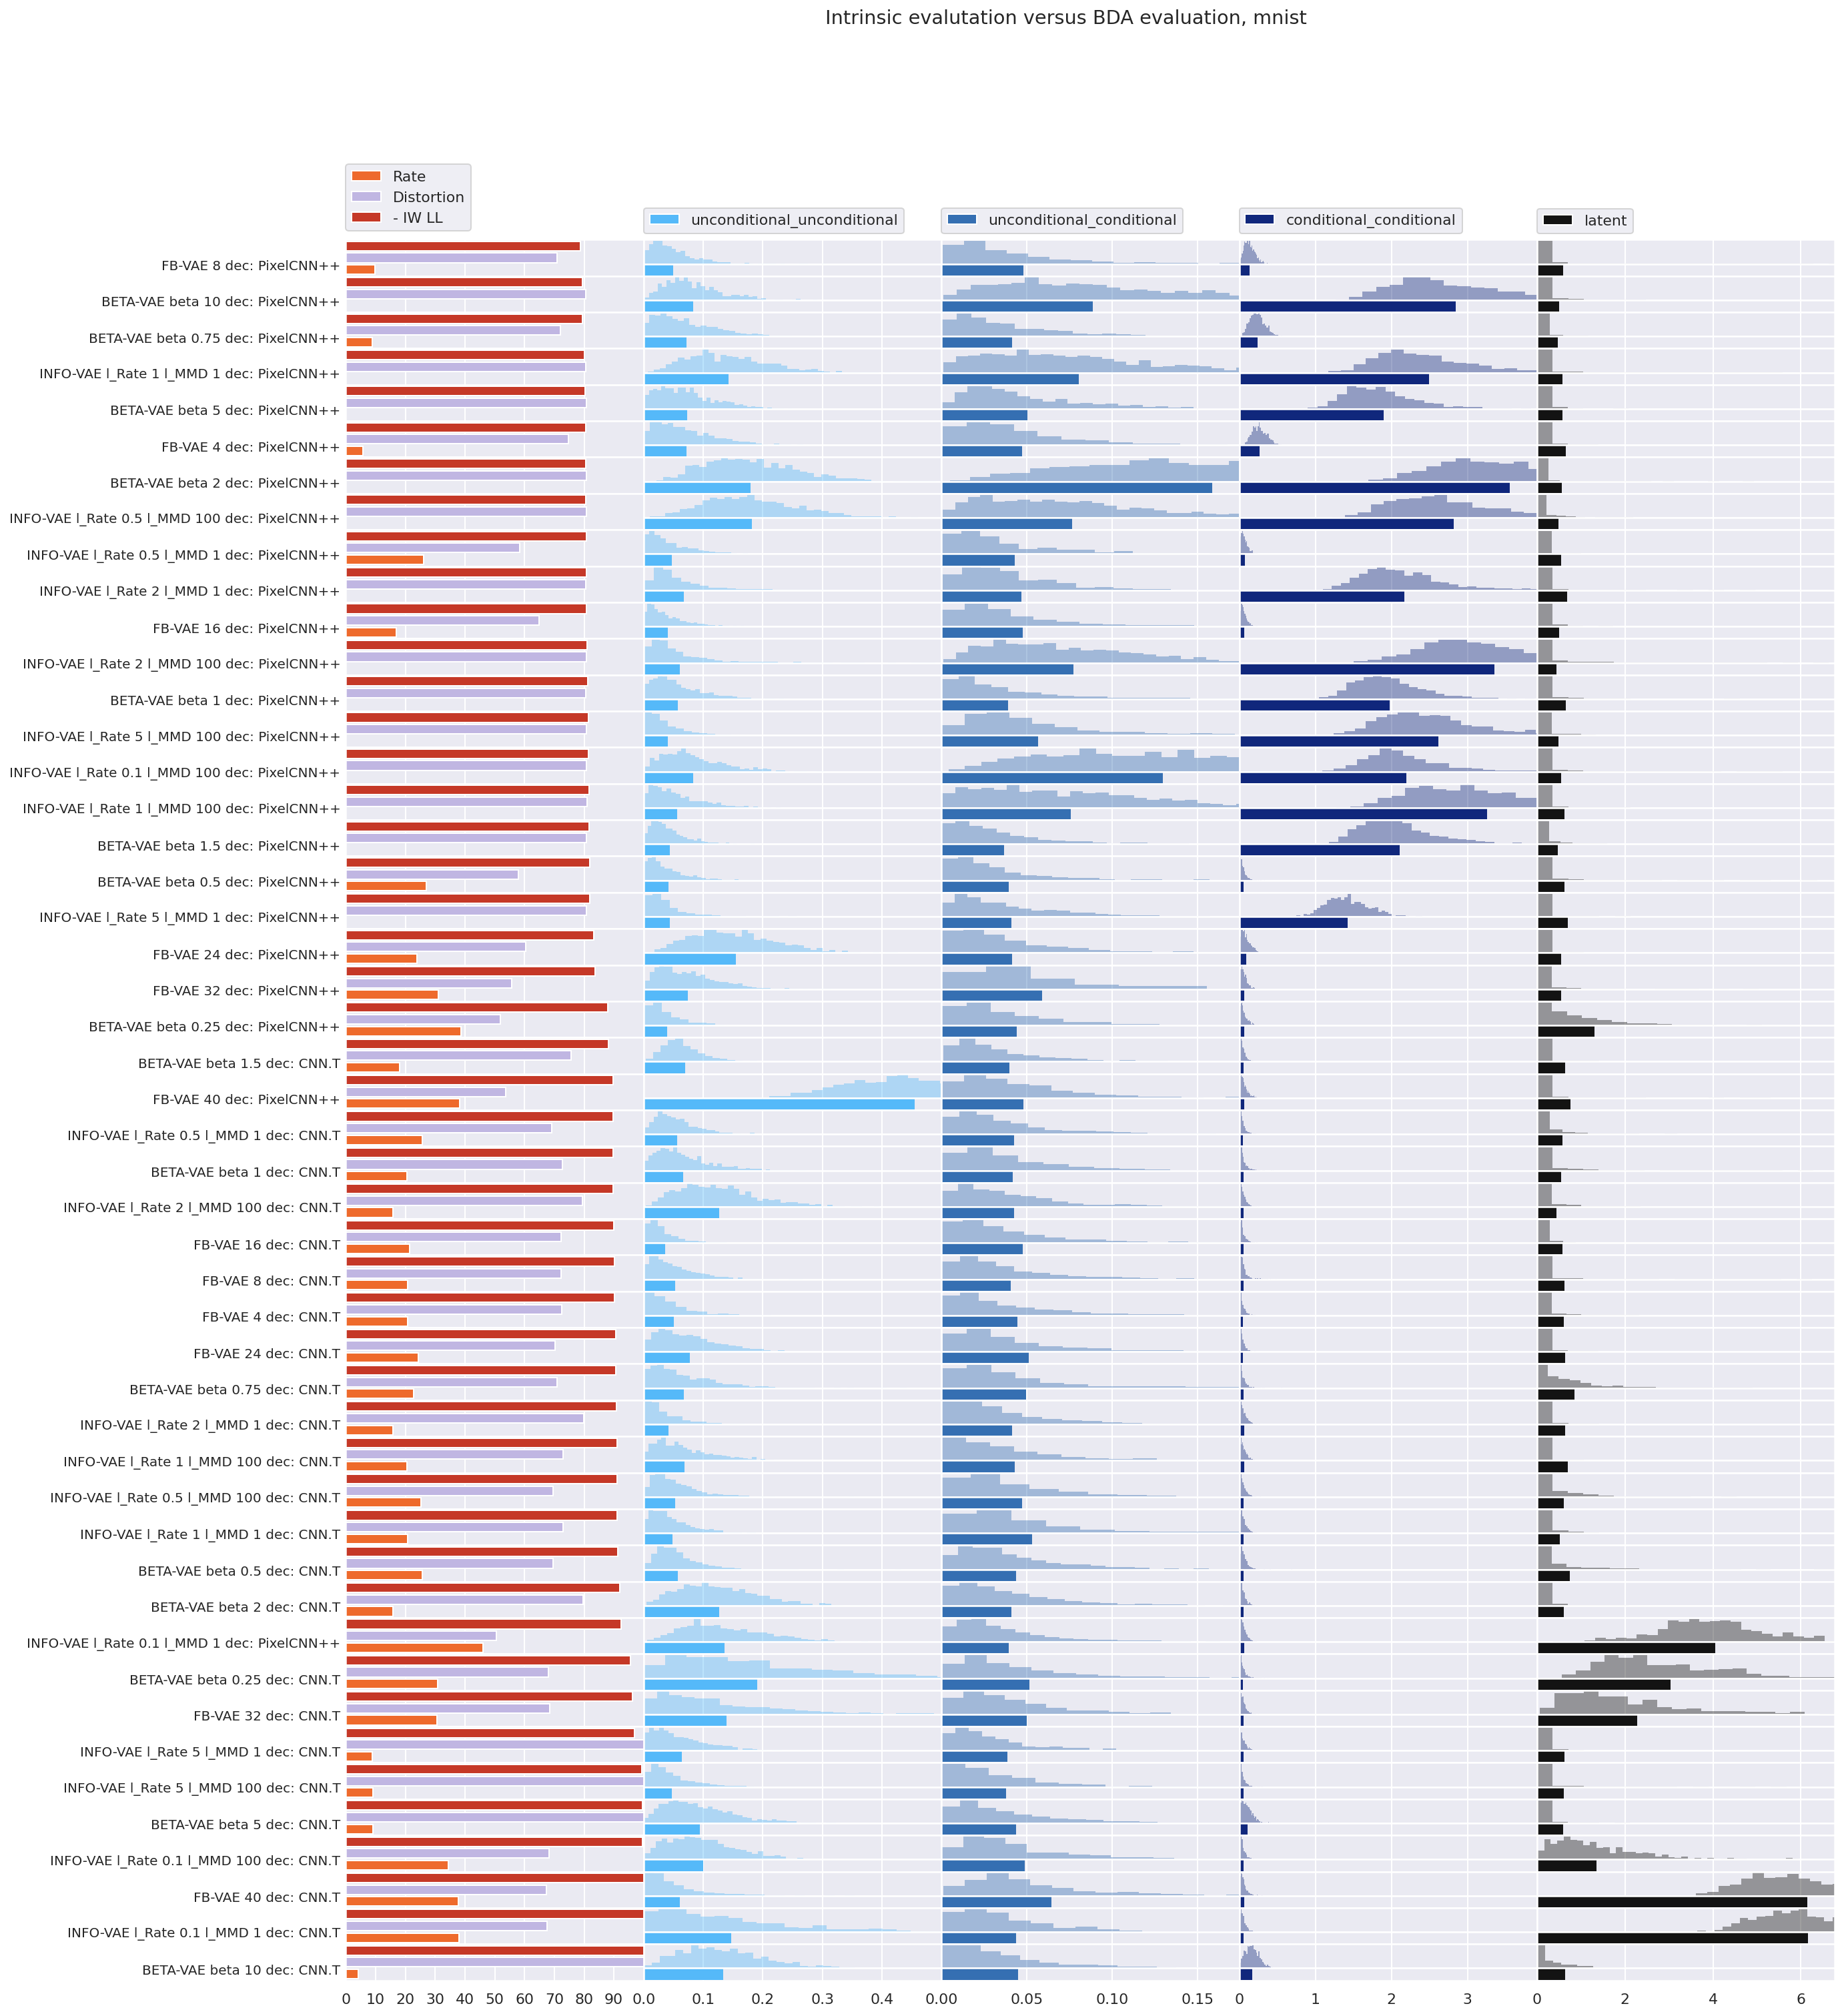

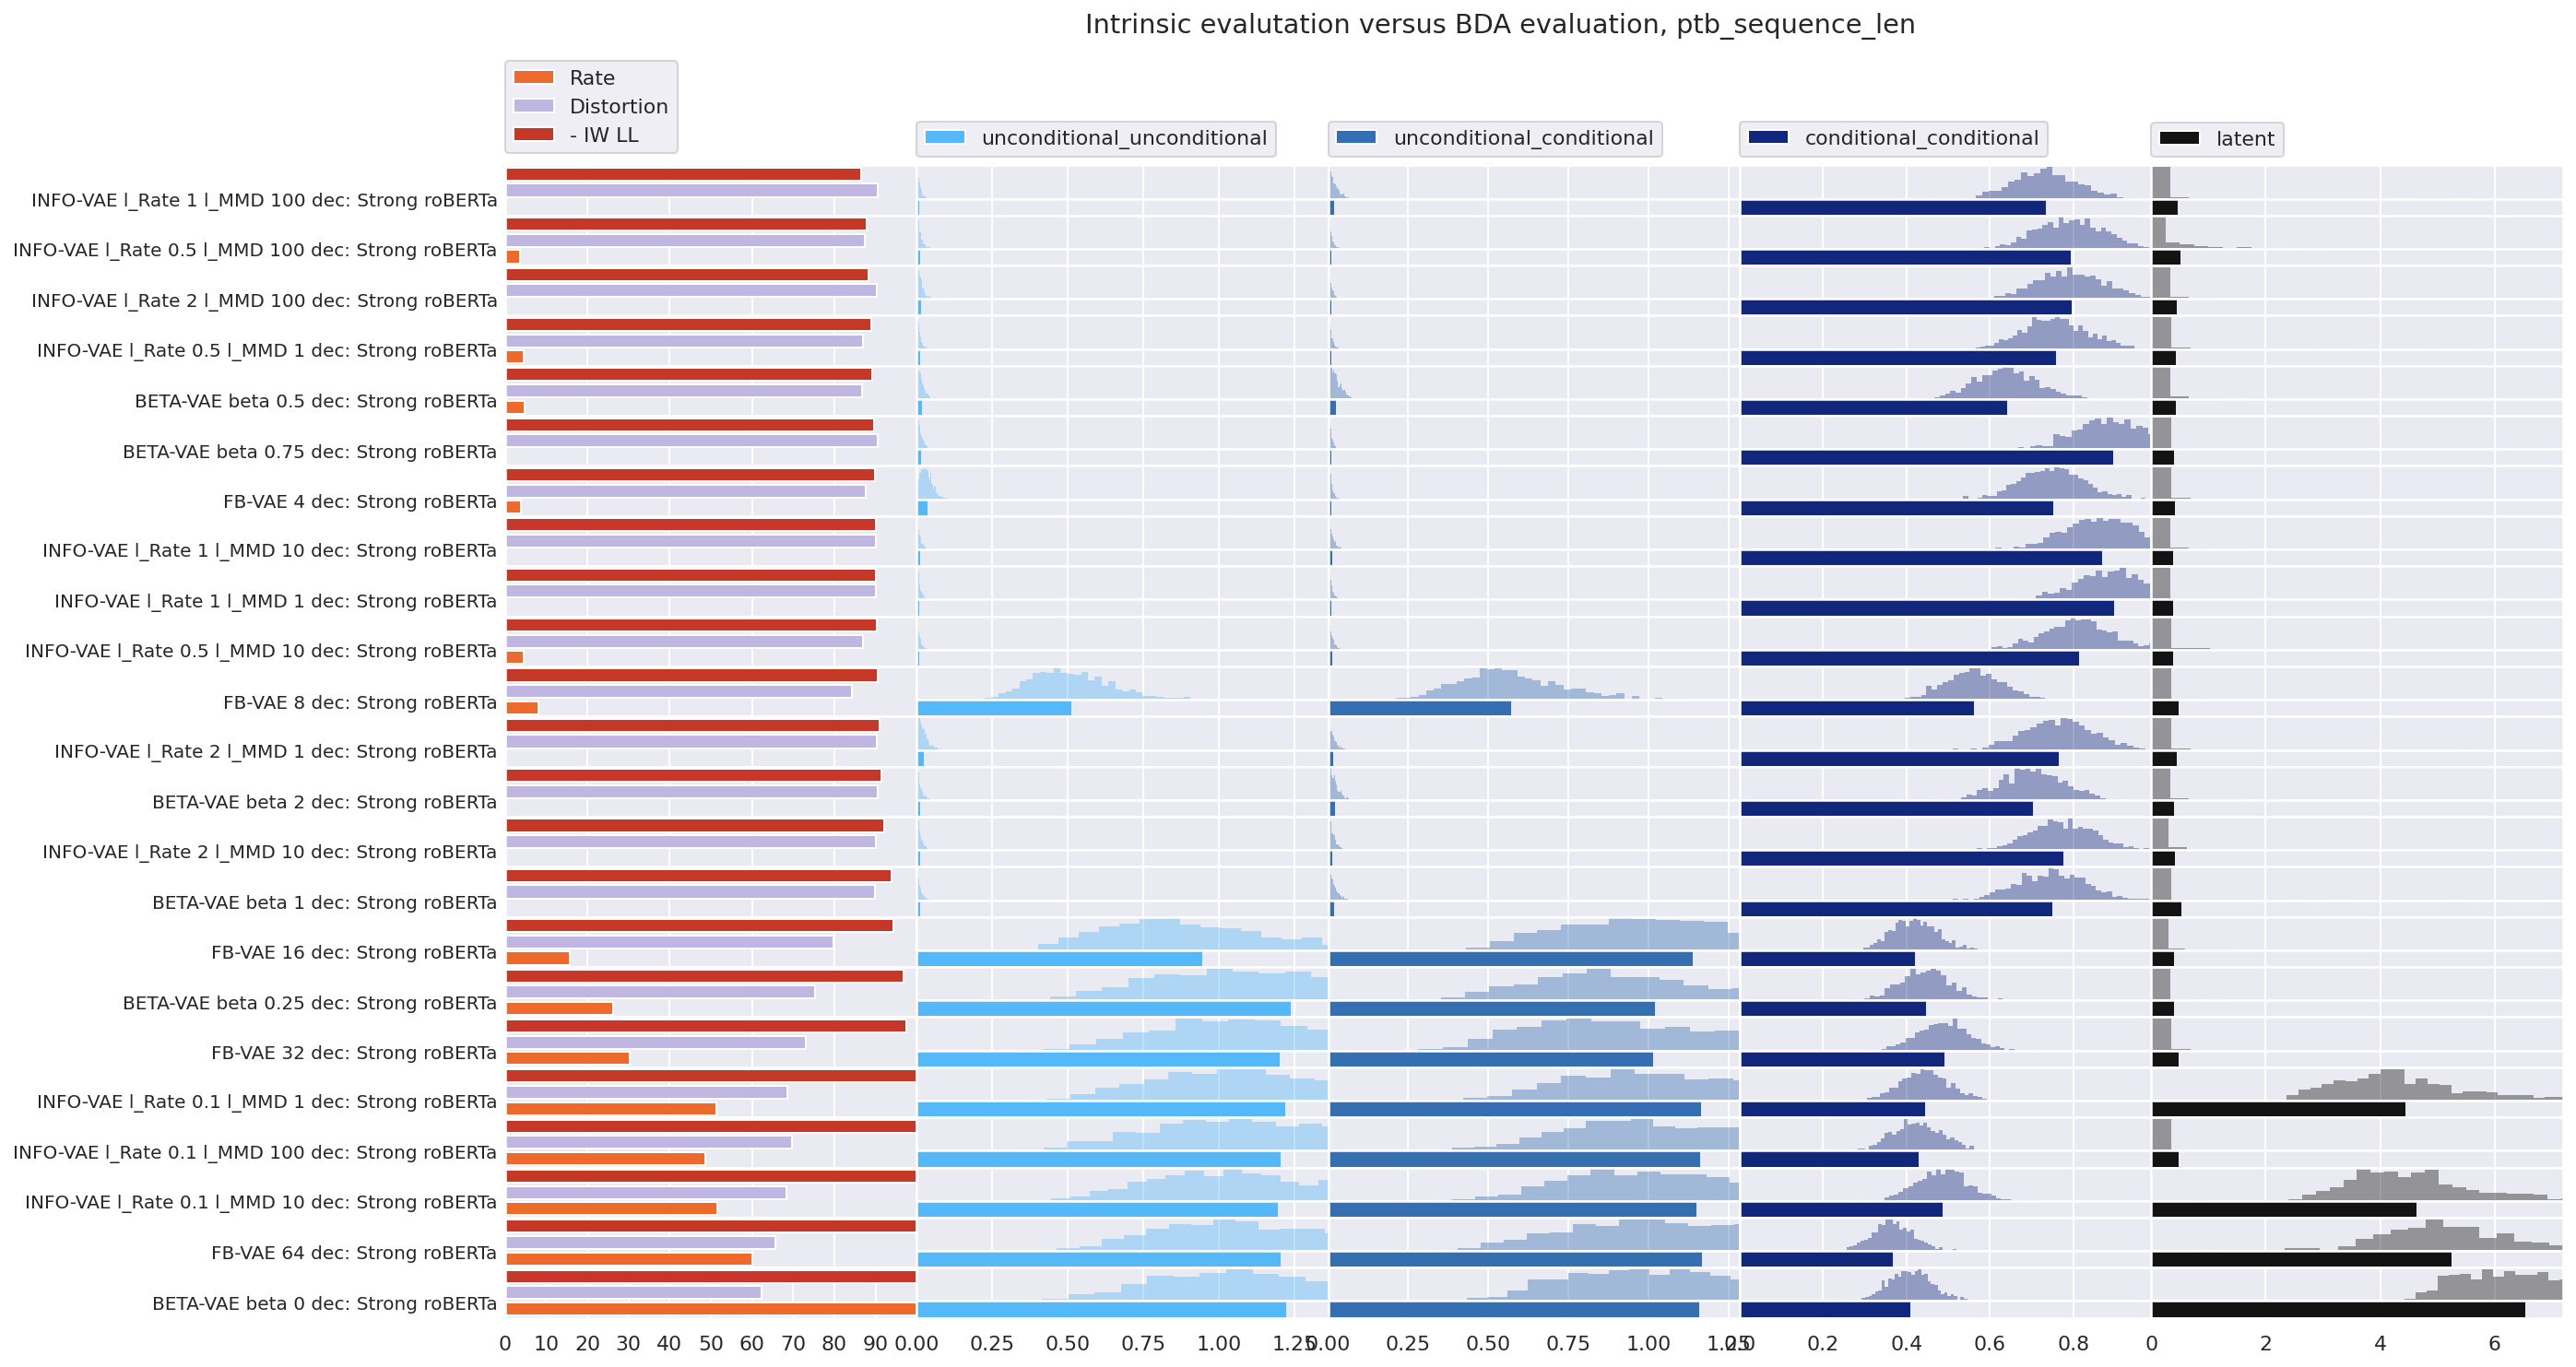

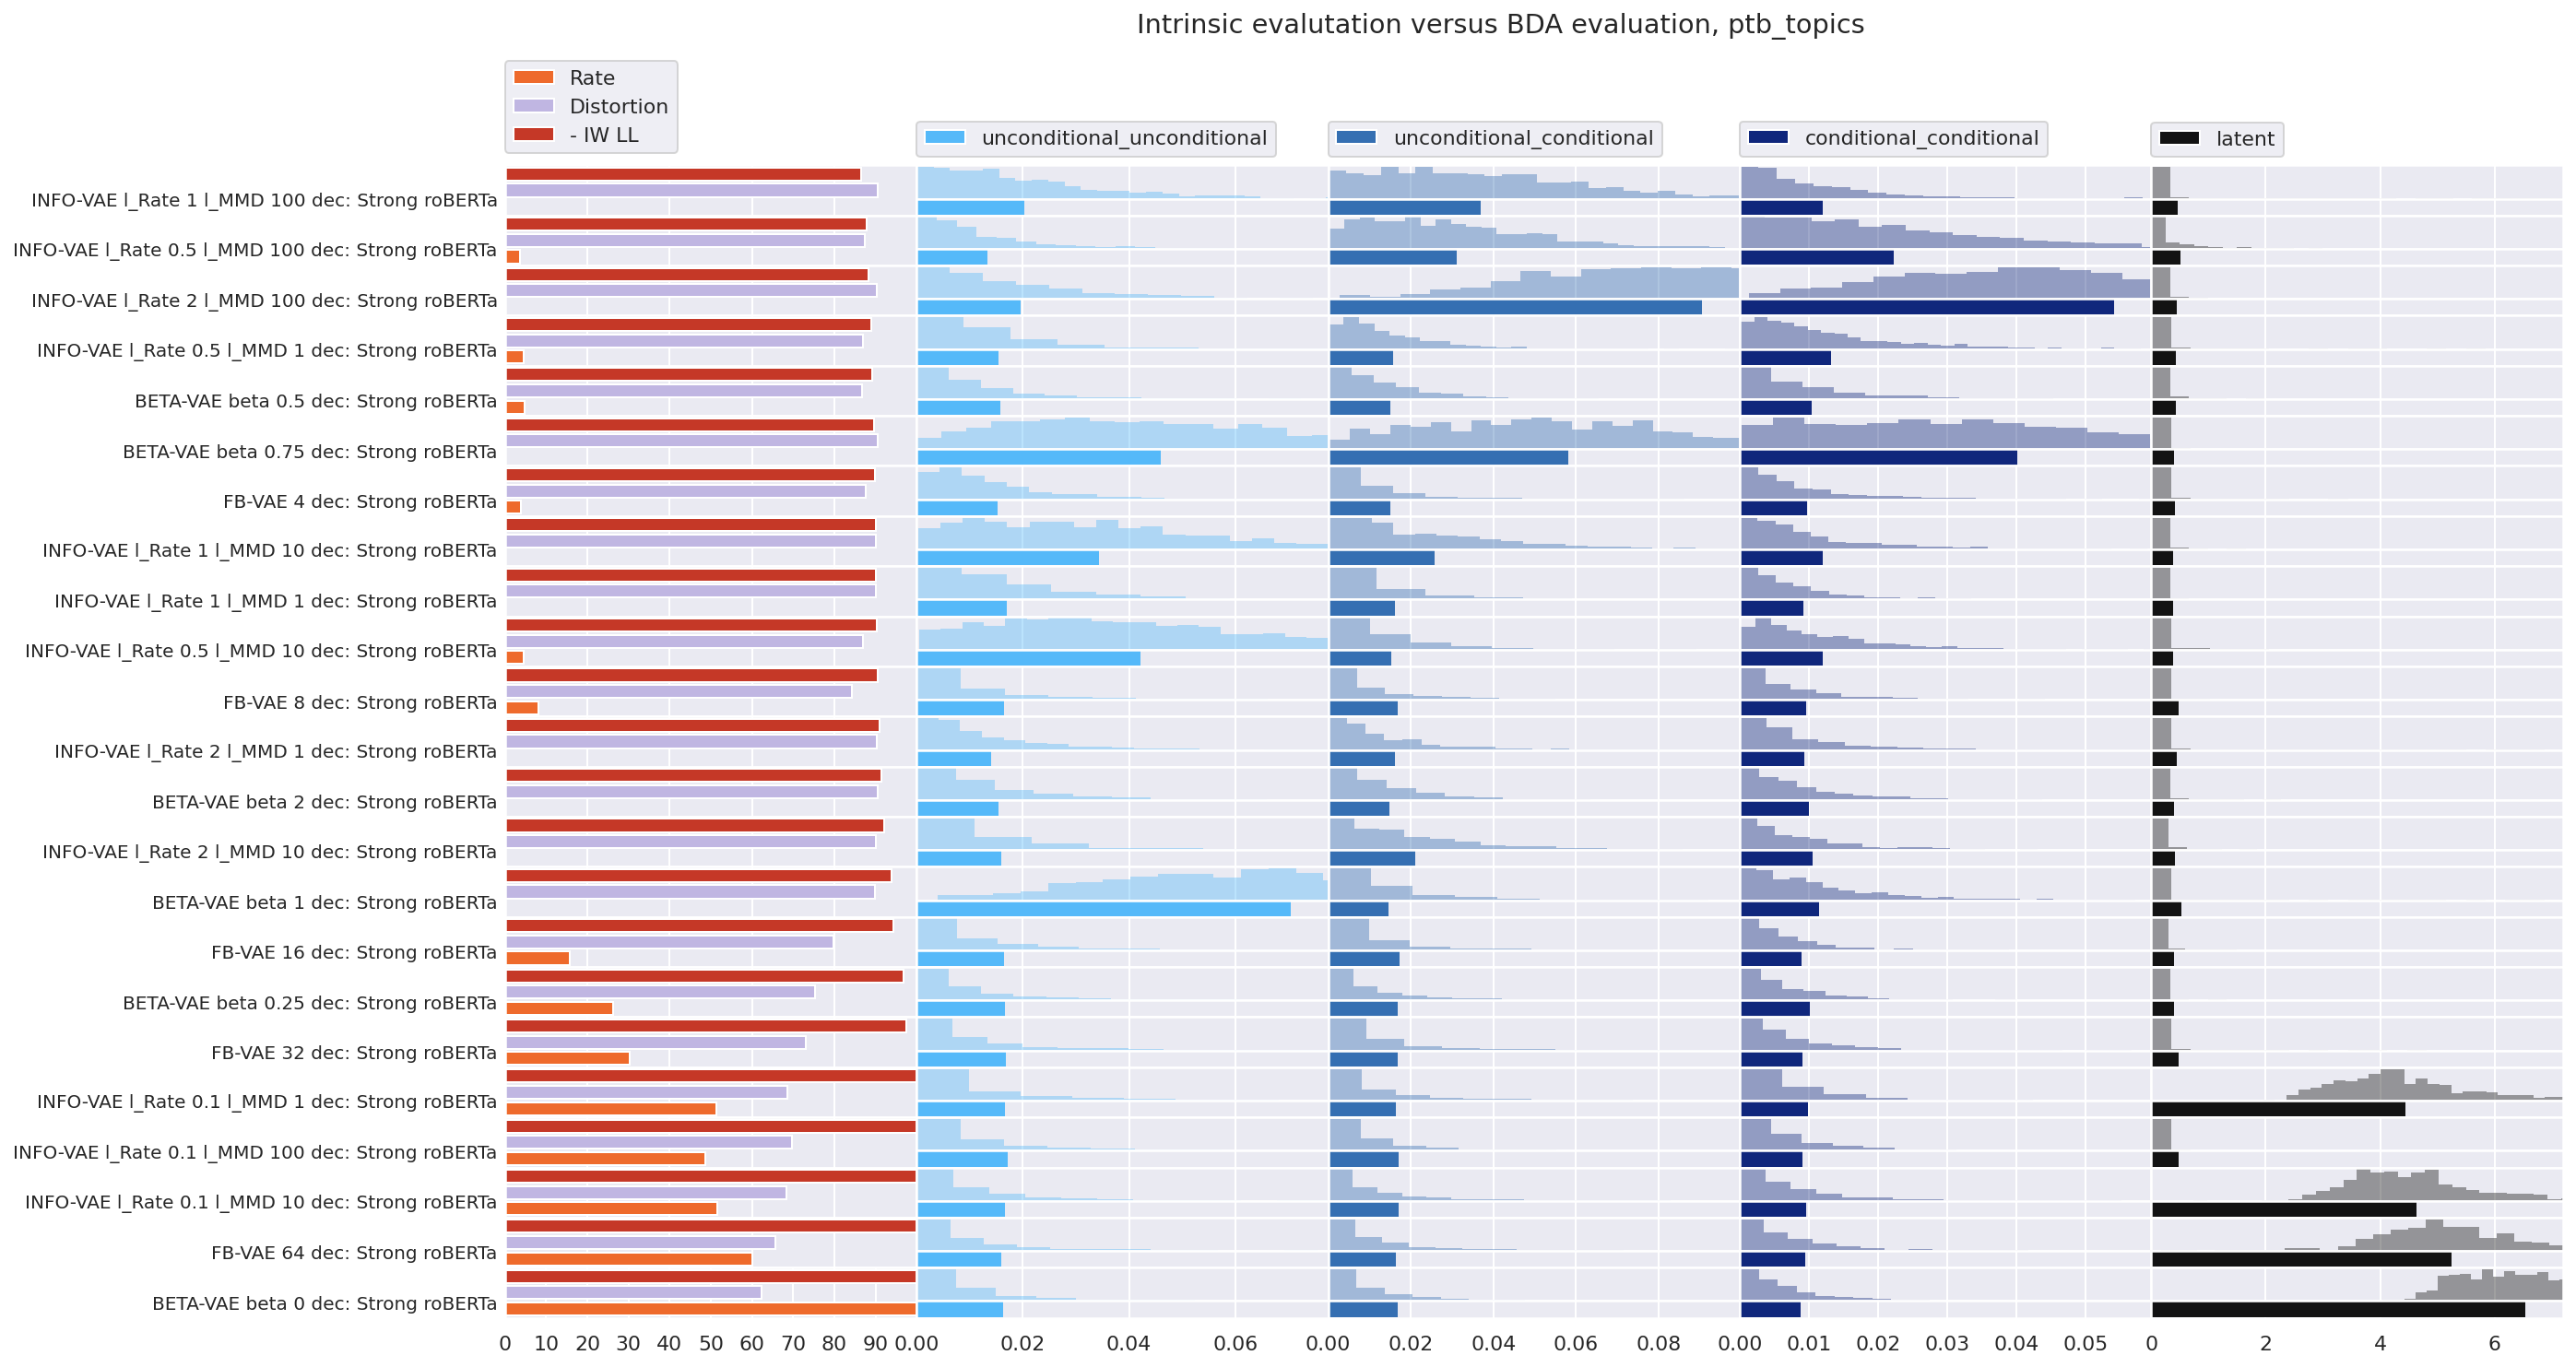

In [28]:
c_dict_plot = {
    "nll": c_dict["red"],
    "rate": c_dict["orange"],
    "distortion": c_dict["purple"],
    "unconditional_unconditional": c_dict["bright_blue"],
    "unconditional_conditional": c_dict["steal_blue"],
    "conditional_conditional": c_dict["dark_blue"],
    "latent": c_dict["black"]
}

# TODO: group_names in better format
# TODO: surprisal stats naming
# TODO: better title
# TODO: okay for the x-axis to be at different scale?

for BDA_TASK in ["mnist", "ptb_sequence_len", "ptb_topics"]:
    
    test_kl = all_kls[BDA_TASK]

    if "mnist" in BDA_TASK:
        test_kl["latent"] = kl_image_latents
        image_or_language = "image"
    else:
        test_kl["latent"] = kl_language_latents
        image_or_language = "language"
    
    KL_plot(global_stats_df=global_stats_df, 
            image_or_language=image_or_language, 
            kl_data=test_kl, 
            c_dict_plot=c_dict_plot, 
            upper_x_lim_LL_bar = 100, 
            title=f"Intrinsic evalutation versus BDA evaluation, {BDA_TASK}",
            max_groups=100)

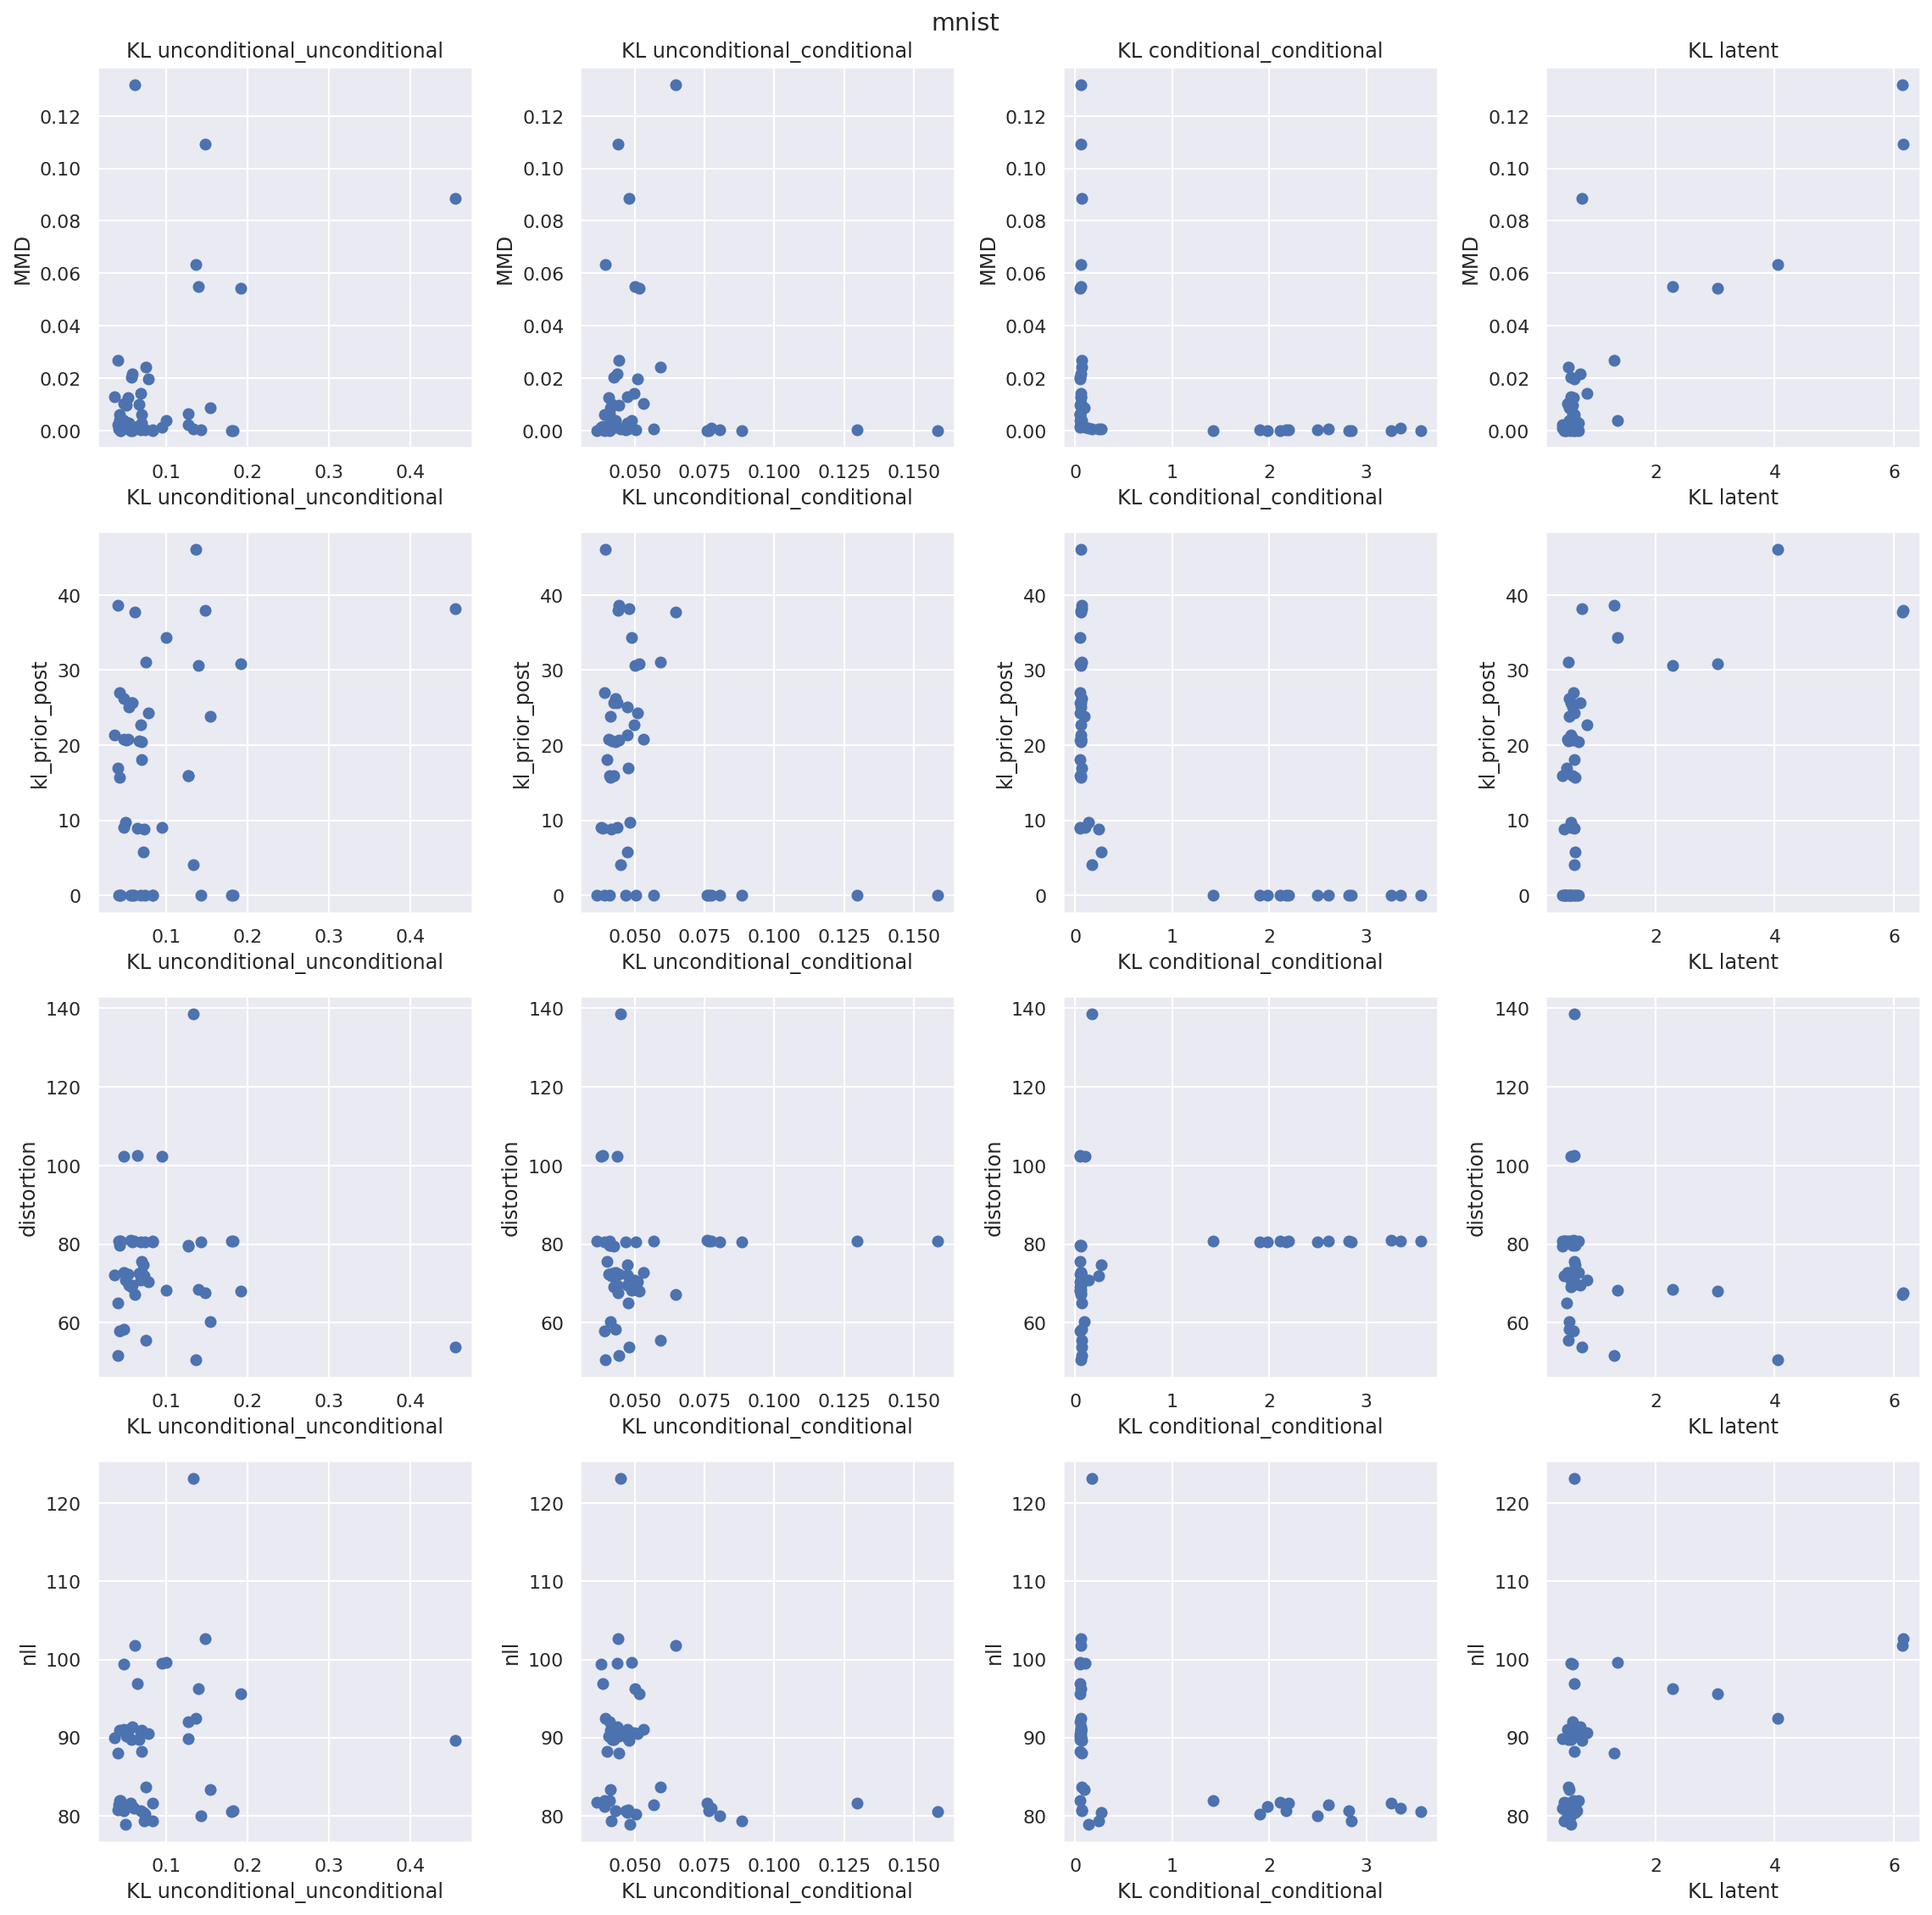

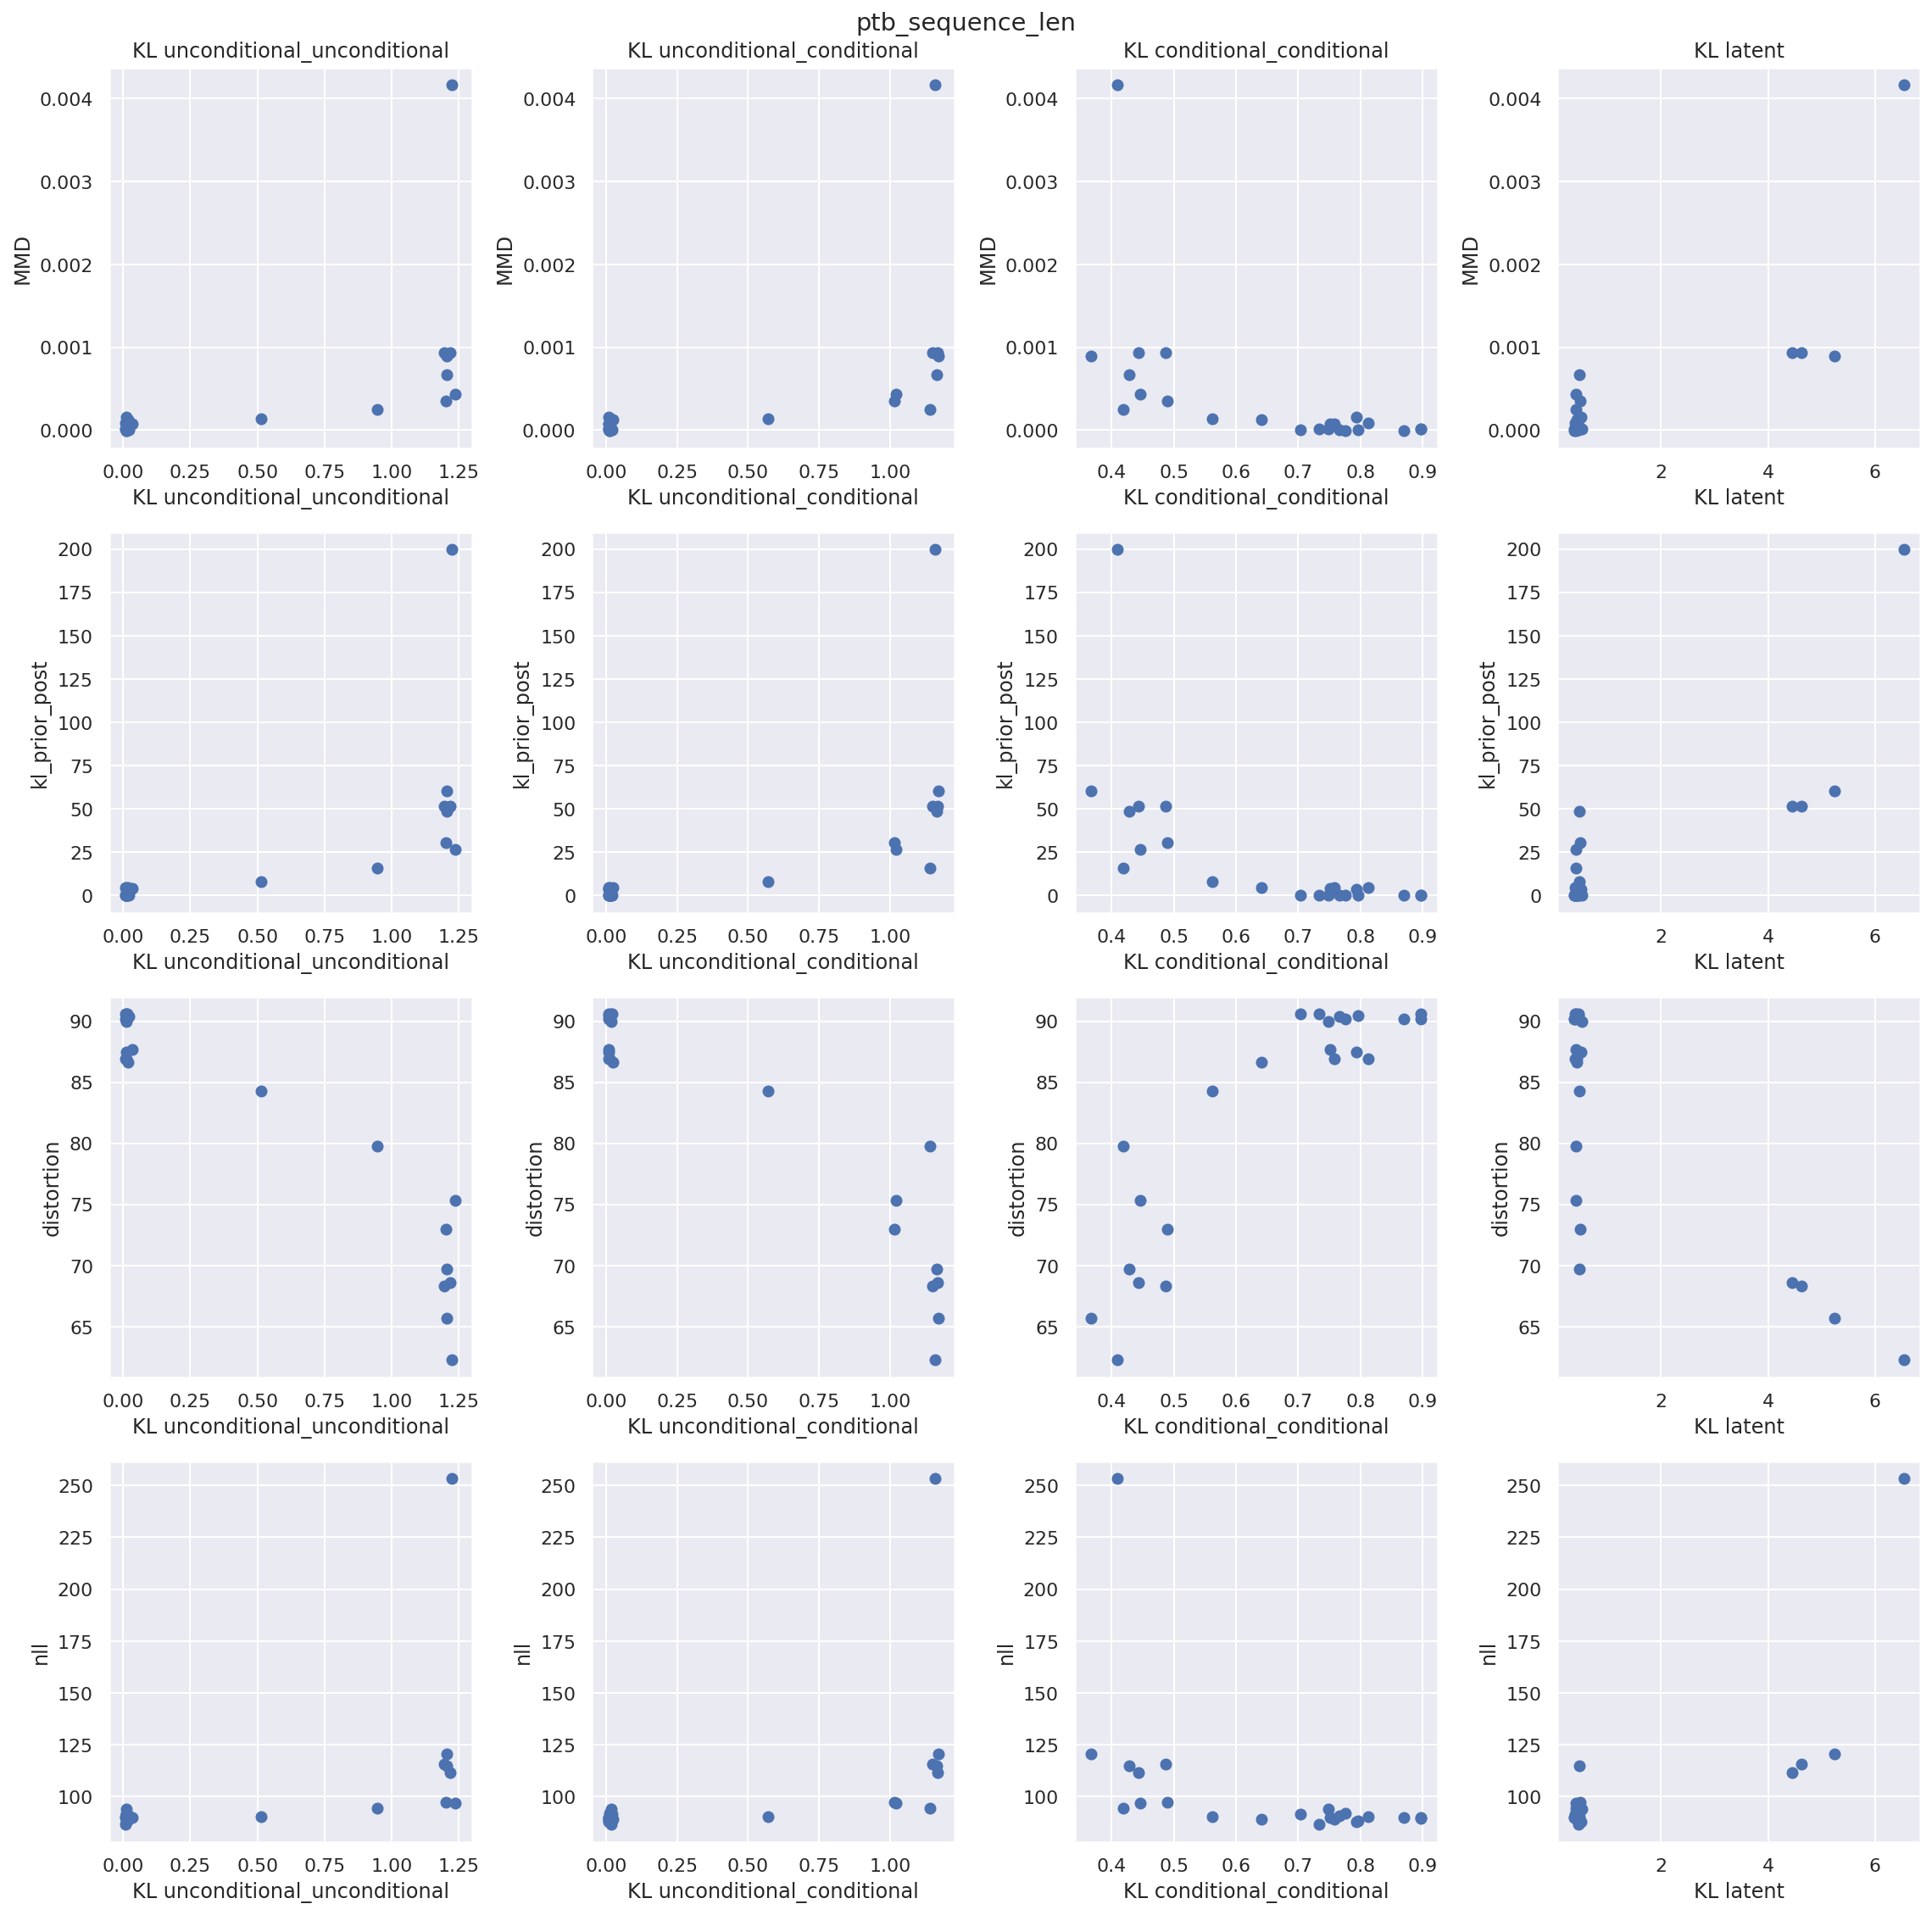

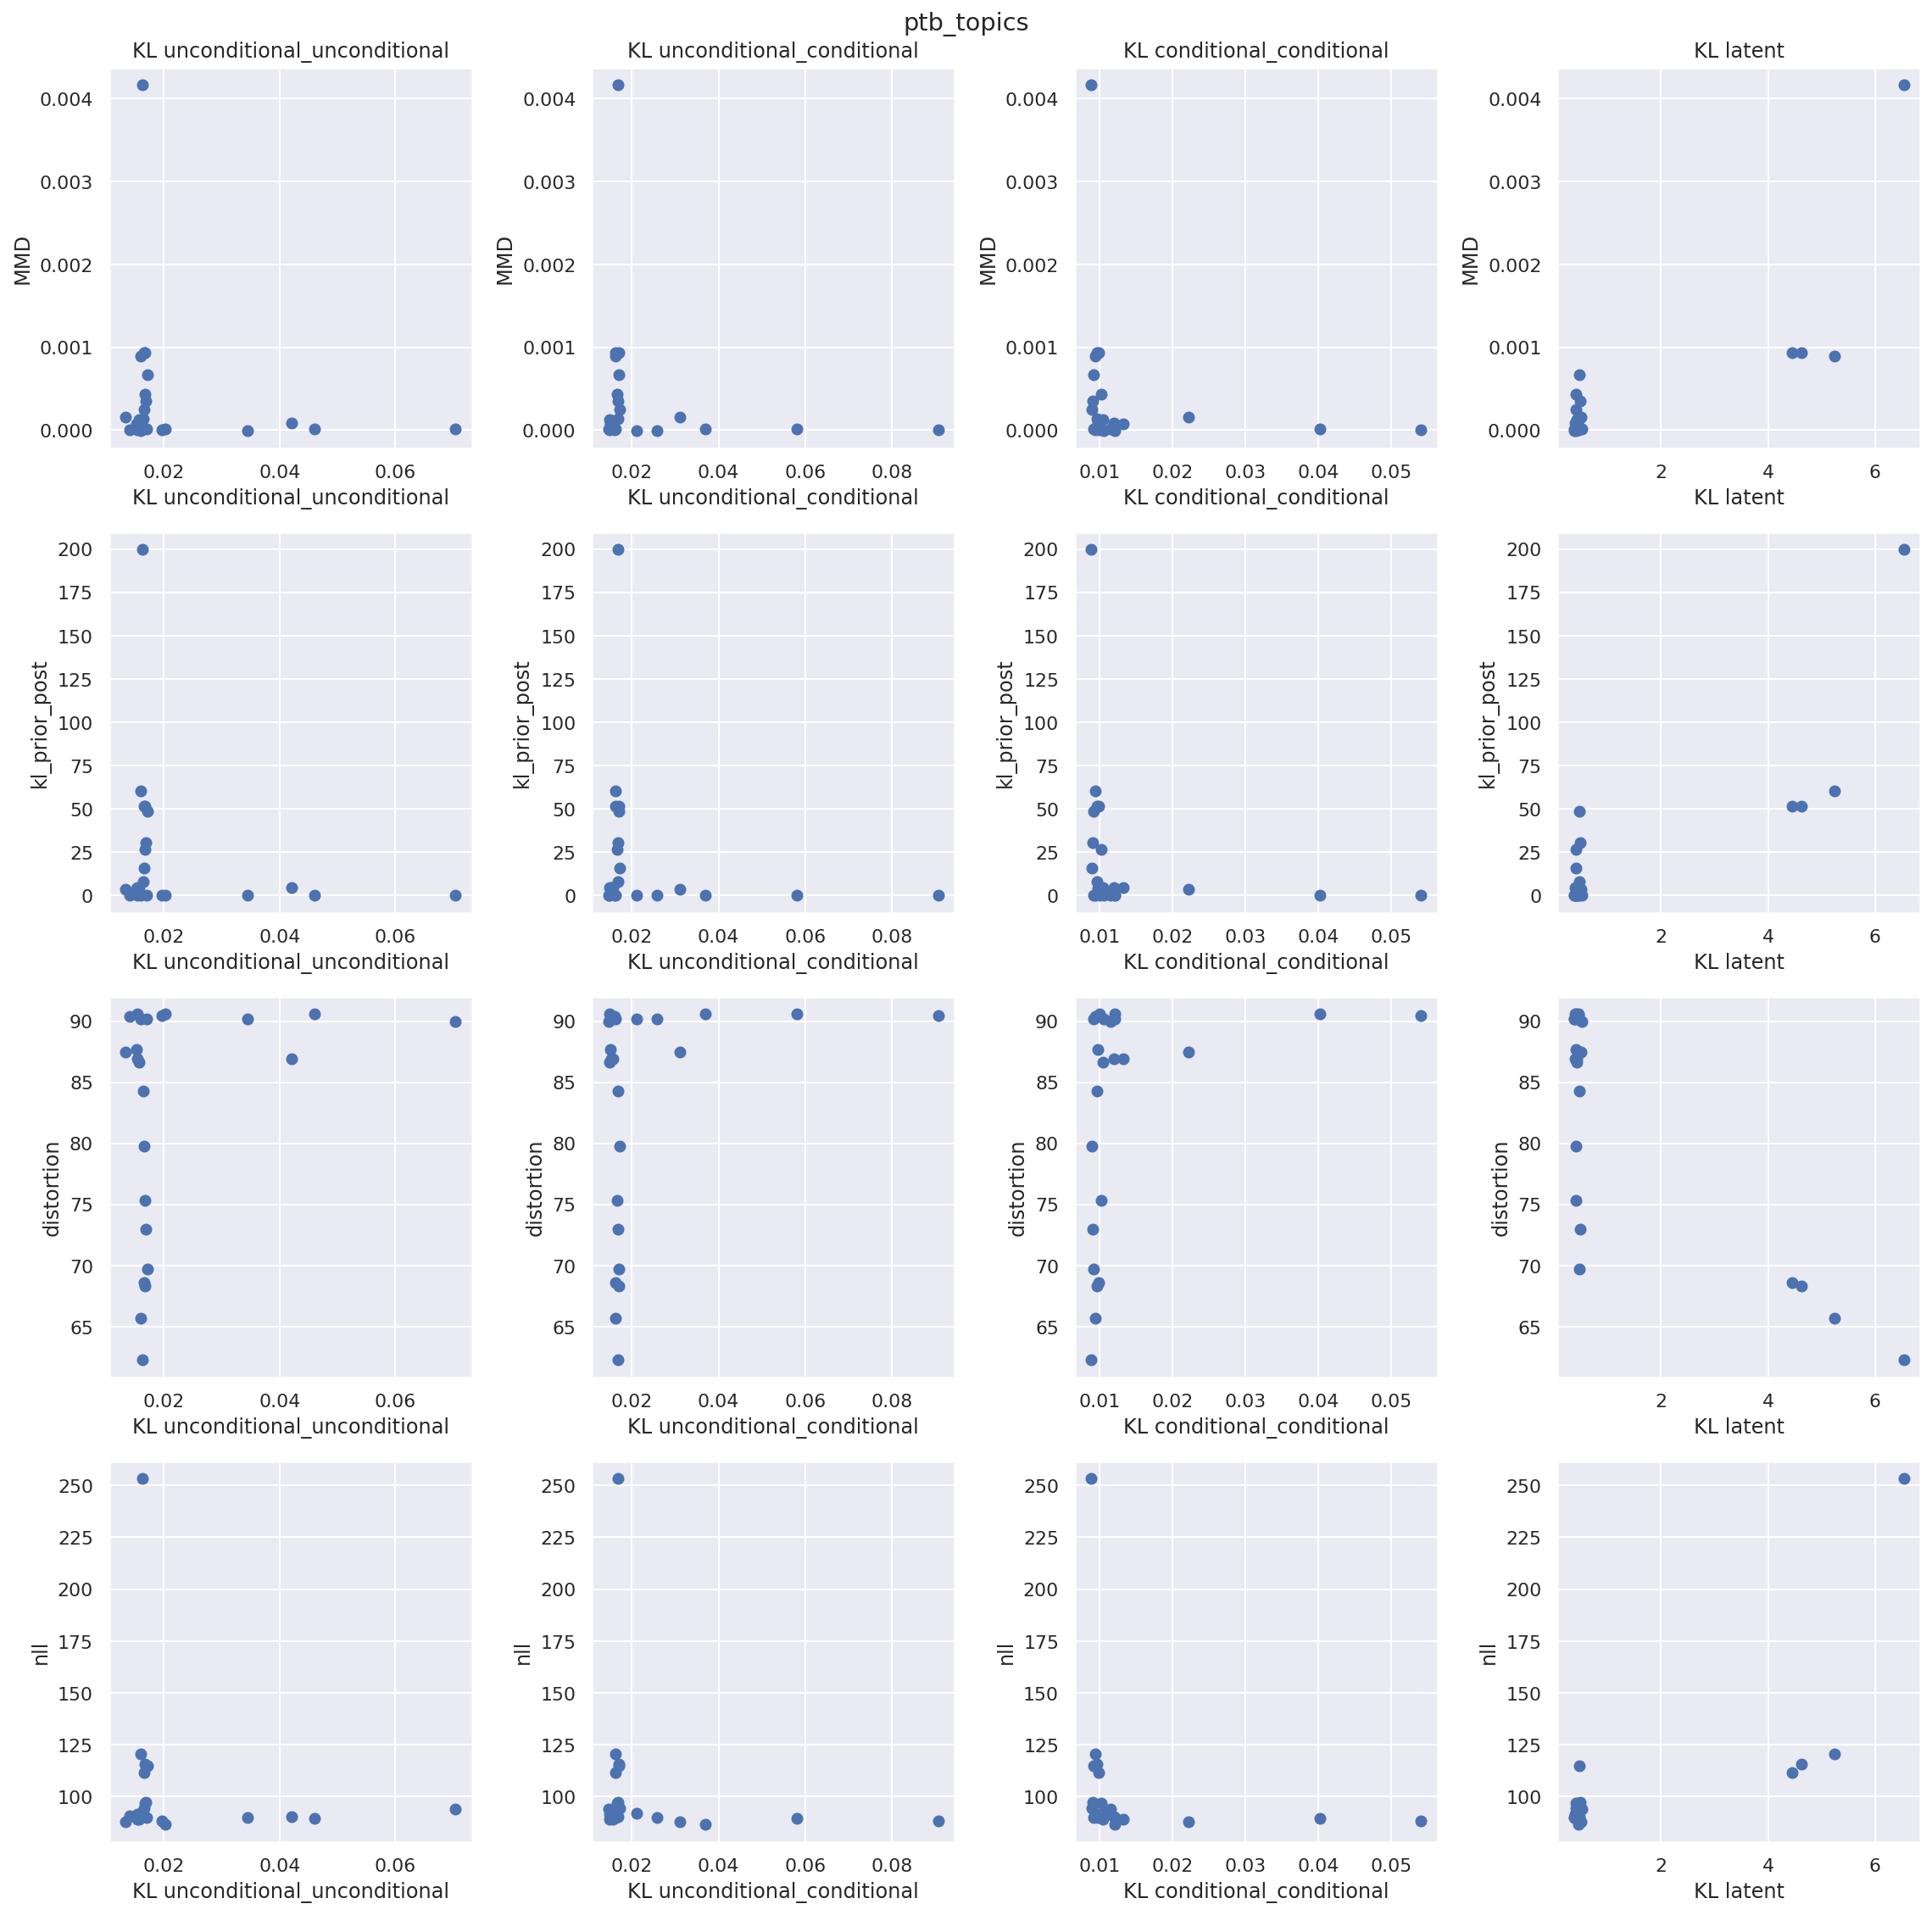

In [46]:
for BDA_TASK in ["mnist", "ptb_sequence_len", "ptb_topics"]:
    
    test_kl = all_kls[BDA_TASK]

    if "mnist" in BDA_TASK:
        test_kl["latent"] = kl_image_latents
        image_or_language = "image"
        
    else:
        test_kl["latent"] = kl_language_latents
        image_or_language = "language"
    
    dframes = []
    for bda_type in ['unconditional_unconditional', 'unconditional_conditional', 'conditional_conditional', 'latent']:
        
        df = test_kl[bda_type]["kl_avg"]
        df = df.rename({"Avg. KL comp": f"KL {bda_type}"}, axis=1)
        
        dframes.append(df)
    kl_df = pd.concat(dframes, axis=1).dropna()
    
    sum_df = global_stats_df[global_stats_df.phase == "valid"][["IW LL", "MMD", "kl_prior_post", "distortion"]]
    sum_df["nll"] = - sum_df["IW LL"]
    sum_df = sum_df.drop("IW LL", axis=1)
    sum_df = sum_df[sum_df.index.isin(kl_df.index)]
    
    all_df = pd.concat([kl_df, sum_df], axis=1)
    
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(4*4, 4*4))
    
    for col, kl_stat in enumerate(["KL unconditional_unconditional", "KL unconditional_conditional", "KL conditional_conditional", "KL latent"]):
        for row, intrinsic_stat in enumerate(["MMD", "kl_prior_post", "distortion", "nll"]):
            if row == 0:
                axs[row, col].set_title(kl_stat)
                
            axs[row, col].scatter(all_df[kl_stat].values, all_df[intrinsic_stat].values)
            axs[row, col].set_xlabel(kl_stat)
            axs[row, col].set_ylabel(intrinsic_stat)
    
    plt.suptitle(BDA_TASK)
    plt.tight_layout()
    plt.show()
    

,IW LL,MMD,kl_prior_post,distortion
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T,-102.698863,0.109114,37.986501,67.664685
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++,-92.494255,0.063386,46.089022,50.566032
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T,-112.413061,0.055015,36.708014,78.978573
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++,-92.755143,0.021386,35.803194,60.909976
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T,-99.629755,0.003865,34.360581,68.233109
...,...,...,...,...
FB-VAE 4 dec: Strong roBERTa,-89.834438,0.000075,3.828506,87.690186
FB-VAE 8 dec: Strong roBERTa,-90.527439,0.000134,8.046714,84.271339
FB-VAE 16 dec: Strong roBERTa,-94.325295,0.000246,15.632185,79.757288
FB-VAE 32 dec: Strong roBERTa,-97.404880,0.000347,30.310549,72.998246


# OLD PLOT CODE BELOW

In [ ]:
# all_df, kl_comp_dists = compute_all_divergences_data_model_groups(dp_mixtures, 
#                                                                   surprisal_values, 
#                                                                   num_components=NUM_COMPS)

# all_keys_present = True
# for k in ["unconditional_unconditional", "unconditional_conditional", "conditional_conditional"]:
#     if k not in kl_comp_dists:
#         all_keys_present = False
# print("all_keys_present", all_keys_present)

# if all_keys_present:
#     torch.save({"kl_comp_dists":kl_comp_dists, "divergence_df": all_df}, SAVE_DP_COMP_KL_DISTS_FILE)

In [ ]:
# SORT_ON = "kl_comp sum"

# all_df = all_df[all_df.index != "data_group"]
# all_df_select = all_df[(run_df.beta_beta < 2) & (run_df.l_mmd < 100)]
# plot_divergences_data_model_groups(all_df_select, sort_on=SORT_ON, plot_only=None)

In [ ]:
# # plot_divergences_data_model_groups(all_df_select, sort_on=SORT_ON, plot_only="kl_comp", figsize=(6, 12))
# # plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only="kl_comp", figsize=(6, 12))
# plot_divergences_data_model_groups(all_df[all_df["kl_comp sum"] < 1.0], sort_on=SORT_ON, plot_only="kl_comp", figsize=(6, 12))

In [ ]:
# global_stats_df_select["-IW LL"] = - global_stats_df_select["IW LL"]

# plot_divergences_data_model_groups_against_other_stat(all_df_select, global_stats_df_select, 
#                                                       plot_against="-IW LL", plot_against_name="-IW LL", 
#                                                       stat="kl_comp", figsize=(14, 18))

# plot_divergences_data_model_groups_against_other_stat(all_df_select, global_stats_df_select, 
#                                                       plot_against="kl_prior_post", plot_against_name="Rate", 
#                                                       stat="kl_comp", figsize=(14, 18))

# plot_divergences_data_model_groups_against_other_stat(all_df_select, global_stats_df_select, 
#                                                       plot_against="distortion", plot_against_name="Distortion", 
#                                                       stat="kl_comp", figsize=(14, 18))



In [3]:
# SAVE_DIR = "output_files"

# files = [f"{SAVE_DIR}/topic_model_dp_mixtures_kl_comp_dists.pt", f"{SAVE_DIR}/MNIST_dp_mixtures_kl_comp_dists.pt"]

# d = torch.load(files[1])
# d.keys()

In [4]:
# all_df, kl_comp_dists = d["divergence_df"], d["kl_comp_dists"]

In [5]:
# from matplotlib.ticker import MaxNLocator
# from matplotlib.gridspec import GridSpec

# # plt.rcParams['axes.grid'] = False
# # plt.rcParams['axes.facecolor'] = "white"

# N_groups = len(list(kl_comp_dists.values())[0])

# c_dict = {"unconditional_unconditional": "#2A26F5",
#           "conditional_conditional": "#E458B3",
#           "unconditional_conditional": "#EF8C7D"}

# max_groups = N_groups - 1 # -1 for data_group

# height_ratios = []
# for _ in range(max_groups):
#     height_ratios.extend([1, 1])
    
# fig = plt.figure(figsize=(8*2, 1.0*max_groups)) #constrained_layout=True, 
# gs = GridSpec(ncols=2, 
#               nrows=max_groups*2, 
#               figure=fig, 
#               height_ratios=height_ratios, 
#               wspace=0.0, 
#               hspace=0.0)
# # fig, axs = plt.subplots(ncols=2, nrows=max_groups*2, figsize=(5*2, 0.5*max_groups), sharex="col", 
# #                         gridspec_kw={"height_ratios":height_ratios})


# stats = ["unconditional_unconditional", "conditional_conditional", "unconditional_conditional"]
# group_names = all_df.sort_values("kl_comp sum").index.values

# max_xlim = 5.0

# col = 1
# group_n = 0

# for i, group_name in enumerate(group_names):
#     print(f"{i:3d}/{len(group_names)}", end="\r")
    
#     #print(group_n, group_name)

#     if group_name == "data_group":
#         continue
        
#     avg_prev = 0.0
#     cum_avgs = [0.0]
#     avgs = []
    
#     row = group_n * 2
    
#     ax = fig.add_subplot(gs[row, col])
#     ax1 = fig.add_subplot(gs[row+1, col])
    
#     for stat in stats:
        
#         kl_comp_vals = kl_comp_dists[stat][group_name]
        
#         ax.hist(np.array(kl_comp_vals)+avg_prev, bins=60, density=True, lw=0, 
#                       color=c_dict[stat], alpha=0.4)
        
#         avg = np.mean(kl_comp_vals)
#         avgs.append(avg)
#         avg_prev += avg
#         cum_avgs.append(avg_prev)
        
#         ax.axvline(avg_prev, color=c_dict[stat], linestyle='--', lw=0.1)
#         ax.set_yticks([])
#         ax.set_xlim([0.0, max_xlim])
    
#     for i in range(3):
#         ax1.barh([''], [avgs[i]], left=[cum_avgs[i]], color=c_dict[stats[i]], lw=0, height=0.1)
    
#     ax.set_ylabel(group_name, rotation="horizontal", ha='right', size=10, y=0.1)
#     ax1.set_xlim([0.0, max_xlim])

#     ax.set_xticklabels([])
#     if (group_n + 1) != (len(group_names) - 1):
#         ax1.set_xticklabels([])
    
#     group_n += 1
    
# print()

# col = 0
# group_n = 0
# for i, group_name in enumerate(group_names):
#     print(f"{i:3d}/{len(group_names)}", end='\r')
    
#     if group_name == "data_group":
#         continue
    
#     row = group_n * 2
#     ax = fig.add_subplot(gs[row+1:row+2, col])
    
#     # Get R, D, LL values for group
#     select = global_stats_df[global_stats_df.index == group_name]
#     nll, r, d = - select["IW LL"].values[0], select["kl_prior_post"].values[0], select["distortion"].values[0]
    
#     # Grouped bar
#     widths = [r, d, nll]
#     ax.barh(["Rate", "Distortion", "NLL"], width=widths, color=['red', 'grey', 'black'])
    
#     # Ticks and lims
#     ax.set_yticks([])
#     ax.set_xlim(180, 0)
#     if (group_n + 1) != (len(group_names) - 1):
#         ax.set_xticklabels([])
#     else:
#         ax.xaxis.set_major_locator(MaxNLocator(prune='lower'))
    
#     group_n += 1

# plt.subplots_adjust(wspace=0.0, hspace=0)